# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

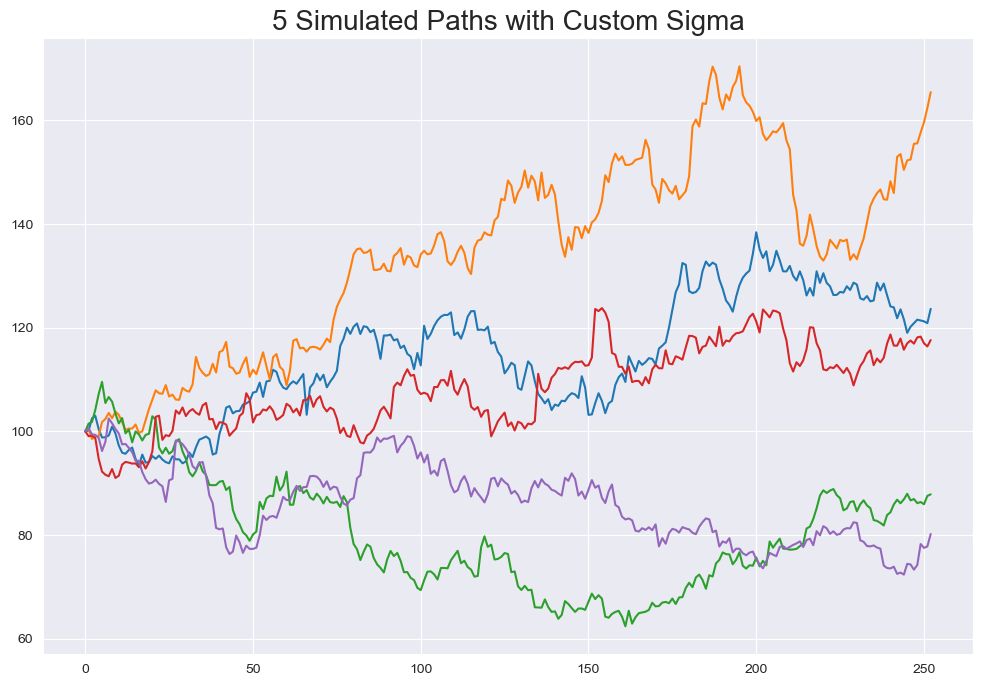

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [4]:
#Import functions associated with Black-Scholes Equations

%run functions_black_scholes.py


import types

# List all functions in functions_black_scholes.py
function_list = [name for name, obj in globals().items() if isinstance(obj, types.FunctionType)]
print(function_list[1:])


['stock_path_custom_sigma', '__nonzero__', 'bs_call', 'bs_put', 'bs_call_delta', 'bs_put_delta', 'bs_gamma', 'bs_vega', 'bs_call_theta', 'bs_put_theta', 'bs_call_rho', 'bs_put_rho', 'bs_MC_call_delta', 'bs_MC_call_delta_array', 'bs_MC_call', 'bs_MC_put_delta', 'bs_MC_put_delta_array', 'bs_MC_put']


In [5]:
# parameters
S0, K = 100, 110
T, r = 1, 0.039
mu = 0.275
sigma_pool = [0.2, 0.3, 0.45]
prob_pool  = [0.5, 0.3, 0.2]

N_steps  = 252        
n_hedges = 12  # hedge once a month
dt = T / N_steps
steps_per_hedge = N_steps // n_hedges # 252/12 = 21 days per hedge

N_paths = 5000 # Monte-Carlo sample size 5000
np.random.seed(1205)

pnl = np.empty(N_paths) #store the P/L of every path

#simulation
for p in range(N_paths):
    S = S0
    cash = 0
    stock = 0
    
    for h in range(n_hedges):              
        t = T - h / n_hedges * T     
        delta_new = bs_call_delta(S, K, 0.3, t, r)
        cash += (delta_new - stock) * S
        stock = delta_new
        
        
        for step in range(steps_per_hedge):
            sigma_t = np.random.choice(sigma_pool, p=prob_pool)
            z = np.random.randn()
            S *= np.exp((mu - 0.5*sigma_t**2)*dt + sigma_t*np.sqrt(dt)*z)
    
    
    pnl[p] = -max(S-K,0) + stock*S - cash

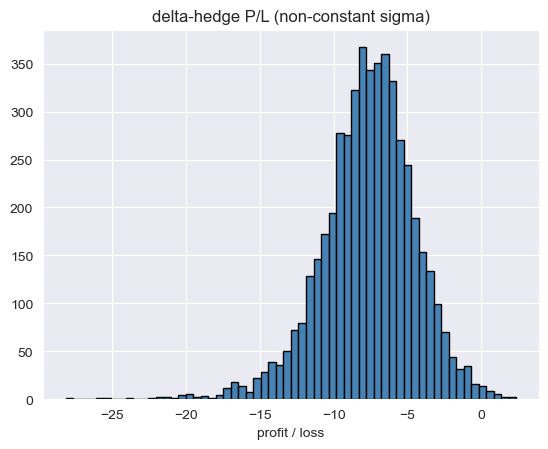

mean profit: -7.6495
std dev:  3.1703
profitable: 0.6%


In [6]:
plt.hist(pnl, bins=60, color='steelblue', edgecolor='k')
plt.title('delta-hedge P/L (non-constant sigma)')
plt.xlabel('profit / loss')
plt.show()

print(f"mean profit: {pnl.mean(): .4f}")
print(f"std dev: {pnl.std(): .4f}")
print(f"profitable: {np.mean(pnl>0)*100:.1f}%")

Interpretation

1. The profit/loss histogram is roughly bell-shaped but most values are negative between -12 and -4, with a long and light left tail reaching about -25. Profitable paths only occupies 0.6 percents. Only a handful of simulated paths (basically those that finish just below the strike and experience mostly low sigma) manage to break even or make money. Almost every other path ends in a loss.


2. The mean is $-7.65$, so the strategy loses about 7.6 dollars per option. Since we used a fixed 30 percents volatility,but the “true” sigma oscillates between 20 percents, 30 percents, 45 percents with a determined distribution. Many times the option we sold is under-priced.


3. This shows that with changing volatility, using only delta-hedge is not enough. The short call still has volatility risk, so the whole P/L moves to the loss side. To make the result better, an extra vega hedge on sigma might help.